In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import DistanceMetric
%matplotlib inline

plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 100)

In [2]:
data_dir = "../data/"
image_dir = "../images/"

target_crop = "soybean"
years = 48 #years of data (1970-2017)

full_data = pd.read_csv(join(data_dir ,"ts_{}_{}yr_df.csv".format(target_crop, years)))

full_data.fips_code = full_data.fips_code.astype(str).apply(lambda x: x.zfill(5))
full_data.set_index('fips_code', inplace=True)
full_data.columns = full_data.columns.astype(int)
full_data.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,23.0,27.0,22.2,18.6,21.0,23.0,23.0,20.0,24.0,29.3,14.0,23.9,23.4,17.1,22.5,29.0,18.0,17.0,25.0,26.8,21.9,22.0,32.8,24.7,37.1,25.0,36.0,26.0,20.0,15.0,25.0,38.0,19.0,39.0,39.0,40.0,20.0,17.0,25.5,38.0,23.3,30.0,47.0,47.9,44.3,45.6,29.2,46.1
01077,22.0,29.0,24.4,19.7,20.0,26.5,22.0,18.0,17.9,24.5,14.0,22.8,27.6,18.6,15.7,32.2,21.8,16.5,17.7,21.0,13.6,25.0,30.5,23.9,27.2,27.0,36.0,27.0,27.0,6.0,9.0,38.0,25.0,37.0,31.0,28.0,24.0,18.0,26.5,39.5,24.5,31.0,46.4,40.1,37.5,46.5,29.9,46.3
01083,22.0,29.0,22.5,24.0,22.0,30.0,26.0,19.9,21.0,27.2,17.9,25.5,29.2,15.5,21.0,32.5,25.0,13.0,23.1,23.2,15.7,26.5,29.9,28.2,32.6,24.0,36.0,30.0,22.0,8.0,17.0,35.0,25.0,39.0,40.0,31.0,16.0,18.0,34.0,44.5,26.0,38.0,48.4,45.0,37.8,47.4,31.8,50.3
01089,21.0,24.0,19.7,18.3,20.0,24.0,22.0,21.0,22.0,26.3,14.0,23.3,28.3,14.7,22.5,29.8,29.0,17.0,24.2,22.3,22.0,28.2,31.0,25.6,36.3,24.0,37.0,27.0,22.0,12.0,20.0,34.0,23.0,36.0,35.0,31.0,16.0,21.0,38.5,42.0,22.6,34.5,46.3,43.6,42.7,45.8,37.6,42.4
05001,26.0,29.0,25.0,29.0,27.0,31.0,27.2,27.6,28.0,31.0,19.0,30.0,29.0,26.0,28.0,30.0,30.0,30.0,32.0,28.0,33.0,34.1,35.0,32.2,38.6,33.0,37.0,38.7,30.4,41.0,35.0,40.0,42.0,45.0,46.0,41.0,46.0,46.0,42.0,45.0,43.2,44.3,50.7,51.8,55.1,53.9,54.4,53.7


### Load predictions DataFrame from [part 1](soybean_imputations_part1.ipynb) for comparison with additional imputation techniques AND to use the same Years for creating "missing" data

In [3]:
part1_preds = pd.read_csv(join(data_dir, "{}_predicitions.csv".format(target_crop)))
part1_preds.fips_code = part1_preds.fips_code.astype(str).apply(lambda x: x.zfill(5))
part1_preds.set_index('fips_code', inplace=True)
part1_preds.head()

,years,y_true,lr_preds,ffill_preds,yr_mean_preds,county_mean_preds,euc_idw1_preds,hav_idw1_preds,euc_idw2_preds,hav_idw2_preds,k1_Nearest_pred,k5_Nearest_pred,k5_Weighted_pred,kRad_Mean_pred
fips_code,,,,,,,,,,,,,,
01049,1994,37.1,27.540418,24.7,27.342553,41.675040,40.516299,40.242988,38.672496,38.096123,36.3,36.78,36.803781,37.650000
01077,1975,26.5,19.112774,20.0,26.102128,28.442607,27.882079,27.672295,26.353785,26.055317,27.0,25.22,25.784720,23.112500
01083,1991,26.5,27.129752,15.7,28.087234,35.051911,33.225538,32.900598,29.885026,29.360571,28.2,27.04,27.605381,25.481818
01089,2003,36.0,31.301652,23.0,27.329787,33.977492,35.715814,35.689299,38.519918,38.443699,39.0,41.00,40.734343,41.222222
05001,1989,28.0,33.888000,32.0,36.657447,32.917994,28.819746,28.631772,23.960732,23.797392,23.0,22.40,22.432626,21.860000


### Years and y_true Values from part 1

In [4]:
pop_list = part1_preds.years.values
pop_list[:5]

array([1994, 1975, 1991, 2003, 1989])

In [5]:
true = part1_preds.y_true.values
true[:5]

array([37.1, 26.5, 26.5, 36. , 28. ])

### Load full test data from part 1 

In [6]:
full_test = pd.read_csv(join(data_dir,"{}_test_df.csv".format(target_crop))) 
full_test.fips_code = full_test.fips_code.astype(str).apply(lambda x: x.zfill(5))
full_test.set_index('fips_code', inplace=True)
full_test.columns = full_test.columns.astype(int)
full_test.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,23.0,27.0,22.2,18.6,21.0,23.0,23.0,20.0,24.0,29.3,14.0,23.9,23.4,17.1,22.5,29.0,18.0,17.0,25.0,26.8,21.9,22.0,32.8,24.7,NaN,25.0,36.0,26.0,20.0,15.0,25.0,38.0,19.0,39.0,39.0,40.0,20.0,17.0,25.5,38.0,23.3,30.0,47.0,47.9,44.3,45.6,29.2,46.1
01077,22.0,29.0,24.4,19.7,20.0,NaN,22.0,18.0,17.9,24.5,14.0,22.8,27.6,18.6,15.7,32.2,21.8,16.5,17.7,21.0,13.6,25.0,30.5,23.9,27.2,27.0,36.0,27.0,27.0,6.0,9.0,38.0,25.0,37.0,31.0,28.0,24.0,18.0,26.5,39.5,24.5,31.0,46.4,40.1,37.5,46.5,29.9,46.3
01083,22.0,29.0,22.5,24.0,22.0,30.0,26.0,19.9,21.0,27.2,17.9,25.5,29.2,15.5,21.0,32.5,25.0,13.0,23.1,23.2,15.7,NaN,29.9,28.2,32.6,24.0,36.0,30.0,22.0,8.0,17.0,35.0,25.0,39.0,40.0,31.0,16.0,18.0,34.0,44.5,26.0,38.0,48.4,45.0,37.8,47.4,31.8,50.3
01089,21.0,24.0,19.7,18.3,20.0,24.0,22.0,21.0,22.0,26.3,14.0,23.3,28.3,14.7,22.5,29.8,29.0,17.0,24.2,22.3,22.0,28.2,31.0,25.6,36.3,24.0,37.0,27.0,22.0,12.0,20.0,34.0,23.0,NaN,35.0,31.0,16.0,21.0,38.5,42.0,22.6,34.5,46.3,43.6,42.7,45.8,37.6,42.4
05001,26.0,29.0,25.0,29.0,27.0,31.0,27.2,27.6,28.0,31.0,19.0,30.0,29.0,26.0,28.0,30.0,30.0,30.0,32.0,NaN,33.0,34.1,35.0,32.2,38.6,33.0,37.0,38.7,30.4,41.0,35.0,40.0,42.0,45.0,46.0,41.0,46.0,46.0,42.0,45.0,43.2,44.3,50.7,51.8,55.1,53.9,54.4,53.7


# Additional Spatial Predictions 

In [8]:
full_data_centroids = pd.read_csv(join(data_dir, "{}_full_centroids.csv".format(target_crop)))
full_data_centroids.fips_code = full_data_centroids.fips_code.astype(str).apply(lambda x: x.zfill(5))
full_data_centroids.set_index('fips_code', inplace=True)
full_spatial = full_data_centroids[['latitude', 'longitude']]
full_spatial.head()

,latitude,longitude
fips_code,,
01049,34.459800,-85.804109
01077,34.901407,-87.654010
01083,34.810099,-86.981401
01089,34.763090,-86.550226
05001,34.290809,-91.374911


# Haversine Distance

In [14]:
counties = full_data.shape[0]
predictions = part1_preds.copy()

full_hav_df = full_spatial.copy()
full_hav_df = np.radians(full_hav_df)

dist = DistanceMetric.get_metric("haversine")
hav_dist_df = pd.DataFrame(dist.pairwise(full_hav_df))
ones = np.ones(counties)

for i in [4, 8, 16, 32]:
    hav_idw = hav_dist_df.copy()
    hav_idw = hav_idw.applymap(lambda x: x**-i if x != 0 else 0)
    hav_idw = hav_idw.apply(lambda x: x/sum(x), axis=1)
    norms_hav_idw = [sum(hav_idw.iloc[j]) for j in hav_idw.columns.values]
    assert(np.allclose(ones, norms_hav_idw))

    hav_idw_vals = np.array(hav_idw).dot(np.array(full_data))

    predictions["hav_idw{}_preds".format(i)] = [hav_idw_vals[j][pop_list[j]-1970] for j in range(counties)]

# K_neighbors

In [16]:
%run spatial_lookup.py

In [17]:
k_n = K_Spatial_Neighbors(full_spatial.values)

k_n.coordinates[0]

array([ 0.60143696, -1.49756422])

In [22]:
neigh_table = k_n.build_neighbors_table(k=10, ret_dist=True)
neighbors_df = pd.DataFrame(neigh_table)
neighbors_df.to_csv(join(data_dir, "{}_k10neighbors.csv".format(target_crop)))
neighbors_df.head()

,0,1,2,3,4,5,6,7,8,9
0,3,579,2,576,581,574,589,586,1,588
1,586,2,581,399,417,3,409,582,424,413
2,3,581,586,1,579,576,0,589,574,417
3,2,579,581,0,576,586,1,589,574,417
4,22,19,23,16,11,25,20,403,401,18


In [20]:
neigh_dist = pd.DataFrame(k_n.srt_dist)
neigh_dist.to_csv(join(data_dir, "{}_k10_distances.csv".format(target_crop)))

neigh_dist.head()

,0,1,2,3,4,5,6,7,8,9
0,47.320760,50.740563,71.169422,72.852064,86.615691,94.328842,101.624148,104.329246,109.444591,154.817881
1,26.270212,38.653423,40.723995,52.512699,52.909537,63.324545,72.061982,78.622381,81.768226,84.152357
2,24.681695,27.255853,36.621232,38.653423,55.694793,69.528374,71.169422,78.125045,86.306922,88.386869
3,24.681695,37.498024,40.899067,47.320760,56.997525,57.226229,63.324545,74.973696,77.317880,112.353363
4,28.459134,30.835042,31.514825,31.813627,32.360775,38.591338,43.367706,44.302967,44.412294,47.788836


In [23]:
def k_neighbors(k, s=1):
    kN_mean_preds, kN_weighted_preds = [], []
    for i in range(counties):
        neighbors = []
        for j in neighbors_df.iloc[i][:k]:
            n = full_data.iloc[j][pop_list[i]]
            neighbors.append(n)
        kN_mean_preds.append(np.mean(neighbors))
        w = list(map(lambda x: x**-s, neigh_dist.iloc[i][:k]))
        kN_weighted_preds.append(np.average(neighbors, weights=w))
        
    return kN_mean_preds, kN_weighted_preds

kN2_mean_preds, kN2_weighted_preds = k_neighbors(2)
kN3_mean_preds, kN3_weighted_preds = k_neighbors(3)
kN4_mean_preds, kN4_weighted_preds = k_neighbors(4)
kN10_mean_preds, kN10_weighted_preds = k_neighbors(10)

print("kN2:", kN2_mean_preds[0], kN2_weighted_preds[0])
print("kN3:", kN3_mean_preds[0], kN3_weighted_preds[0])
print("kN4:", kN4_mean_preds[0], kN4_weighted_preds[0])
print("kN10:", kN10_mean_preds[0], kN10_weighted_preds[0])

kN2: 37.15 37.12035698775539
kN3: 35.63333333333333 35.963247152640605
kN4: 36.725 36.770766414765454
kN10: 36.51 36.73320456730036


# Predictions

In [24]:
predictions["k2_Nearest_pred"] = kN2_mean_preds
predictions["k2_Weighted_pred"] = kN2_weighted_preds
predictions["k3_Nearest_pred"] = kN3_mean_preds
predictions["k3_Weighted_pred"] = kN3_weighted_preds
predictions["k4_Nearest_pred"] = kN4_mean_preds
predictions["k4_Weighted_pred"] = kN4_weighted_preds
predictions["k10_Nearest_pred"] = kN10_mean_preds
predictions["k10_Weighted_pred"] = kN10_weighted_preds

predictions.head()

,years,y_true,lr_preds,ffill_preds,yr_mean_preds,county_mean_preds,euc_idw1_preds,hav_idw1_preds,euc_idw2_preds,hav_idw2_preds,k1_Nearest_pred,k5_Nearest_pred,k5_Weighted_pred,kRad_Mean_pred,hav_idw4_preds,hav_idw8_preds,hav_idw16_preds,hav_idw32_preds,k2_Nearest_pred,k2_Weighted_pred,k3_Nearest_pred,k3_Weighted_pred,k4_Nearest_pred,k4_Weighted_pred,k10_Nearest_pred,k10_Weighted_pred
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,1994,37.1,27.540418,24.7,27.342553,41.675040,40.516299,40.242988,38.672496,38.096123,36.3,36.78,36.803781,37.650000,36.767475,36.885707,36.717381,36.464622,37.15,37.120357,35.633333,35.963247,36.725,36.770766,36.51,36.733205
01077,1975,26.5,19.112774,20.0,26.102128,28.442607,27.882079,27.672295,26.353785,26.055317,27.0,25.22,25.784720,23.112500,26.431226,27.051798,27.005141,27.000012,28.50,28.213897,27.666667,27.599568,26.275,26.625672,23.40,24.354031
01083,1991,26.5,27.129752,15.7,28.087234,35.051911,33.225538,32.900598,29.885026,29.360571,28.2,27.04,27.605381,25.481818,28.660781,29.175111,28.836888,28.352492,30.10,30.005831,28.400000,28.697921,27.550,27.964168,25.86,26.753710
01089,2003,36.0,31.301652,23.0,27.329787,33.977492,35.715814,35.689299,38.519918,38.443699,39.0,41.00,40.734343,41.222222,39.774833,39.140379,39.003103,39.000002,39.50,39.396941,41.333333,40.891983,40.750,40.537428,39.71,40.276886
05001,1989,28.0,33.888000,32.0,36.657447,32.917994,28.819746,28.631772,23.960732,23.797392,23.0,22.40,22.432626,21.860000,22.745059,22.806553,22.864183,22.999700,23.50,23.479965,23.333333,23.326593,23.000,23.007631,23.44,23.317958


# "Full Data" predictions 

In [25]:
full_LR = pd.read_csv(join(data_dir, "{}_lin_reg_preds.csv".format(target_crop)), 
                      index_col="fips_code")
full_LR.columns = full_LR.columns.astype(int)
full_LR.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1049,22.425172,26.871233,19.607363,22.932593,23.094288,24.494904,25.807911,17.297255,19.929672,26.241453,15.157439,21.826438,27.179618,12.960647,24.746821,25.284163,24.480703,16.359612,20.507260,22.903168,21.809658,25.909381,32.440320,22.929523,34.023161,25.492597,32.928555,24.553934,23.855959,16.039236,21.643162,33.090306,21.857008,41.129109,37.085115,29.096910,27.323807,22.167793,33.524026,40.246152,23.484824,33.973190,34.706326,41.862758,43.201256,36.859466,37.216821,49.693876
1077,26.718221,26.213245,21.470442,20.221964,19.053899,22.175618,22.076070,21.005448,20.459455,28.119754,13.861651,25.988975,24.162401,16.784565,21.688112,26.067852,23.676911,13.595065,24.344216,16.637182,19.914951,17.786859,31.413608,22.505418,33.987782,24.739555,30.777071,29.400464,18.261520,14.962511,18.146513,27.779966,21.935420,38.201433,37.088025,28.112987,17.844458,17.054113,30.882177,36.392951,23.730451,24.164537,36.334629,45.067623,38.105519,35.304732,41.541804,46.363638
1083,24.503725,29.231976,23.244873,20.995080,23.602600,25.316598,25.720013,21.527861,19.955096,29.676259,11.646700,28.102842,27.727487,16.676342,24.613518,30.576634,21.023659,15.915582,24.235215,17.230071,22.207396,22.340275,35.110541,24.597712,34.860027,24.020497,32.810345,26.470860,22.485803,16.027152,16.754490,33.564187,20.482772,44.572646,40.846824,29.676167,22.914884,17.561584,35.036278,36.804651,25.353276,28.663402,41.349274,40.254631,42.368177,40.817356,39.545987,49.704598
1089,18.928249,23.760443,22.937319,21.157055,23.016679,22.605892,20.524771,21.247310,19.975632,26.461614,13.302982,27.990024,26.013074,18.751163,27.337874,29.972825,19.419477,19.620969,22.763155,18.963390,21.040646,22.261129,33.754825,27.021715,31.043421,24.495840,31.188390,29.648429,23.223356,16.954249,18.481013,33.214487,20.939161,40.182684,41.105253,32.682559,25.052729,19.781896,29.668789,36.724062,28.732621,32.611886,36.334033,39.752473,38.839757,38.829323,36.994450,49.909669
5001,25.978228,25.793159,27.093659,29.332657,24.624301,28.893618,27.928286,27.203352,27.294093,30.681640,24.601786,27.592435,29.757591,26.856687,31.693849,32.451705,26.959724,30.913146,31.083906,33.536918,31.694022,36.097899,38.085812,30.920140,39.429063,29.765866,38.252989,37.484057,33.797092,32.651683,37.444565,40.580834,39.255045,39.274450,42.279515,42.369079,42.191865,42.085976,42.703116,46.447681,46.971705,44.262778,49.383162,52.531471,51.755248,51.418094,54.200344,56.824200


In [26]:
FULL_LR_preds = [full_LR.iloc[i][pop_list[i]] for i in range(counties)]
FULL_LR_preds[:5]

[34.02316128917613,
 22.175618206410178,
 22.340274926123772,
 40.18268422439733,
 33.53691801087856]

In [27]:
full_HAV_LR = pd.read_csv(join(data_dir, "{}_lr_hav_idw_preds.csv".format(target_crop)), 
                          index_col="fips_code")
full_HAV_LR.columns = full_HAV_LR.columns.astype(int)

FULL_HAV_LR_preds = [full_HAV_LR.iloc[i][pop_list[i]] for i in range(counties)]

In [28]:
full_HAV_IDW2_LR = pd.read_csv(join(data_dir, "{}_lr_hav_idw2_preds.csv".format(target_crop)),
                               index_col="fips_code")
full_HAV_IDW2_LR.columns = full_HAV_IDW2_LR.columns.astype(int)

FULL_HAV_LR_IDW2_preds = [full_HAV_IDW2_LR.iloc[i][pop_list[i]] for i in range(counties)]

In [29]:
predictions["FULL_LR_pred"] = FULL_LR_preds
predictions["FULL_HAV_LR_IDW_pred"] = FULL_HAV_LR_preds
predictions["FULL_HAV_LR_IDW2_pred"] = FULL_HAV_LR_IDW2_preds

In [30]:
def mape(y_pred,y_true):
    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
pred_cols = [col for col in predictions.columns if "pred" in col]
MAPE, MAE, R2, RMSE = [], [], [], []

for col in pred_cols:
    MAPE.append(mape(predictions["y_true"], predictions[col]))
    MAE.append(median_absolute_error(predictions["y_true"], predictions[col]))
    R2.append(r2_score(predictions["y_true"], predictions[col]))
    RMSE.append(np.sqrt(mean_squared_error(predictions["y_true"], predictions[col])))
    
metric_df = pd.DataFrame({"MAPE": MAPE, "MAE":MAE, "RMSE":RMSE, "RSQUARED":R2}, 
                         index=[col.upper() for col in pred_cols])
metric_df

,MAPE,MAE,RMSE,RSQUARED
LR_PREDS,12.717789,3.691601,5.653820,0.700357
FFILL_PREDS,17.915291,4.200000,7.498800,0.472888
YR_MEAN_PREDS,19.316394,5.910638,8.590884,0.308176
COUNTY_MEAN_PREDS,17.917507,5.866981,7.945045,0.408285
EUC_IDW1_PREDS,14.011552,4.379573,6.420803,0.613545
HAV_IDW1_PREDS,13.822370,4.280468,6.358312,0.621031
EUC_IDW2_PREDS,9.249546,2.650806,4.285224,0.827866
HAV_IDW2_PREDS,9.095557,2.569139,4.217454,0.833267
K1_NEAREST_PRED,8.924507,2.300000,4.013614,0.848995
K5_NEAREST_PRED,6.928398,1.760000,3.126954,0.908344


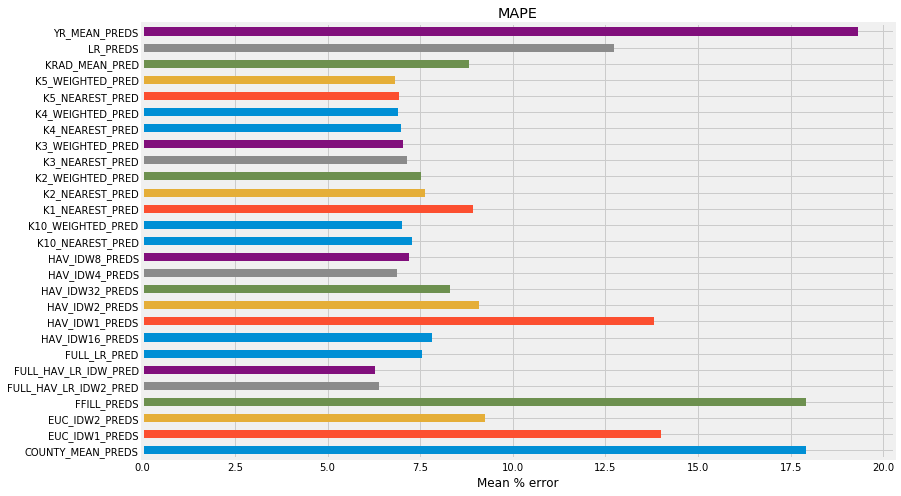

In [39]:
metric_df["MAPE"].sort_index().plot(kind="barh", title=col, figsize=(12, 8))
plt.xlabel("Mean % error")
plt.title('MAPE')
plt.show();

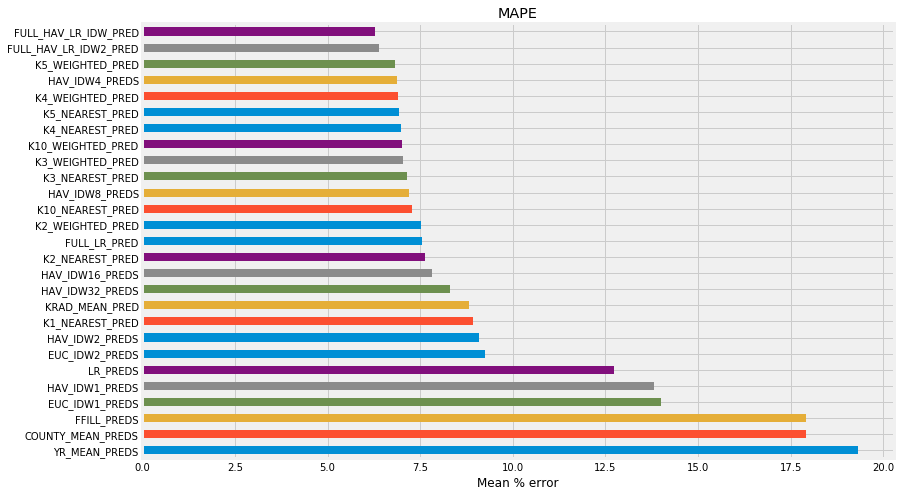

In [35]:
metric_df['MAPE'].sort_values(ascending=False).plot(kind="barh", title=col, figsize=(12, 8))
plt.xlabel("Mean % error")
plt.title('MAPE')
plt.show();

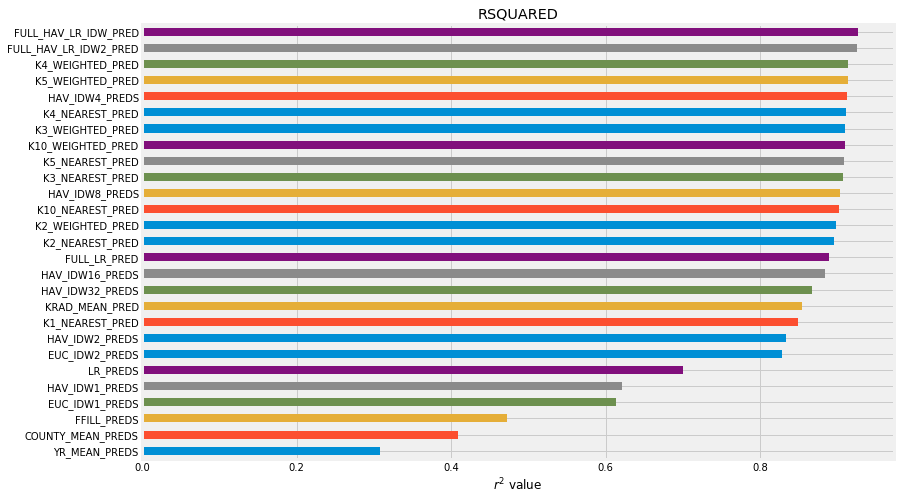

In [42]:
metric_df['RSQUARED'].sort_values().plot(kind="barh", title=col, figsize=(12,8))
plt.xlabel("$r^2$ value")
plt.title('RSQUARED')
plt.show();

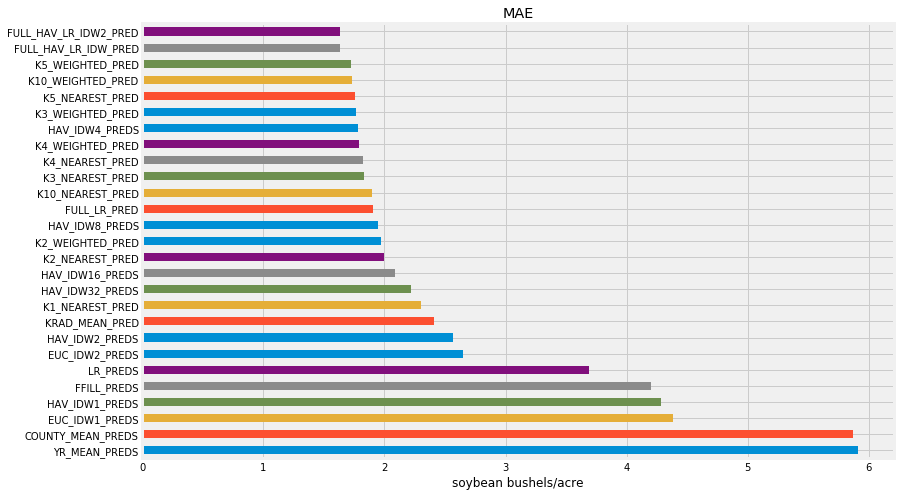

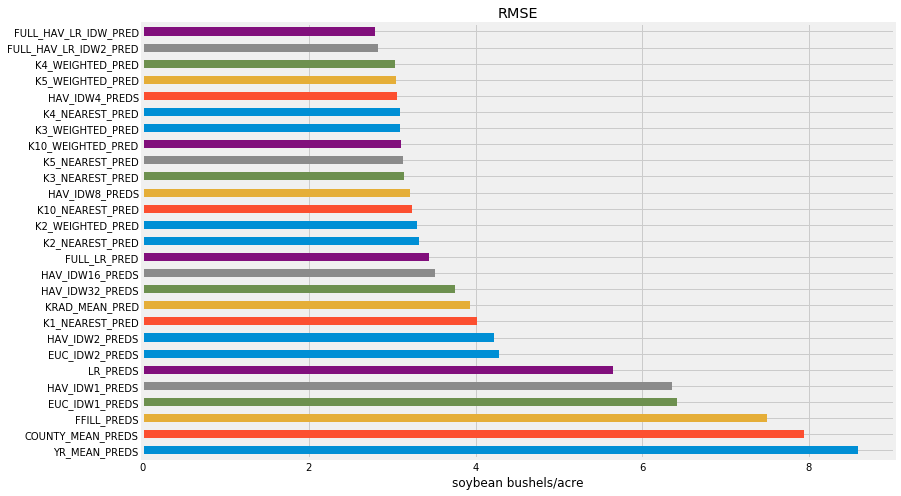

In [41]:
for m in ['MAE', 'RMSE']:  
    metric_df[m].sort_values(ascending=False).plot(kind="barh", title=col, figsize=(12,8))
    plt.xlabel("{} bushels/acre".format(target_crop))
    plt.title(m)
    plt.show();

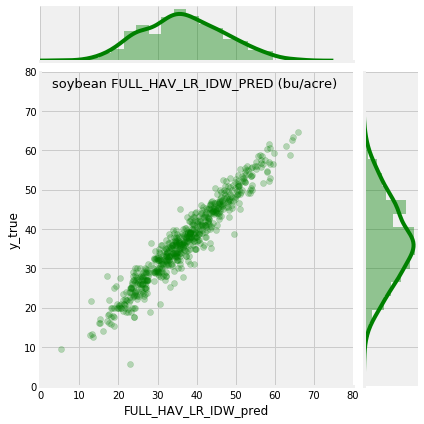

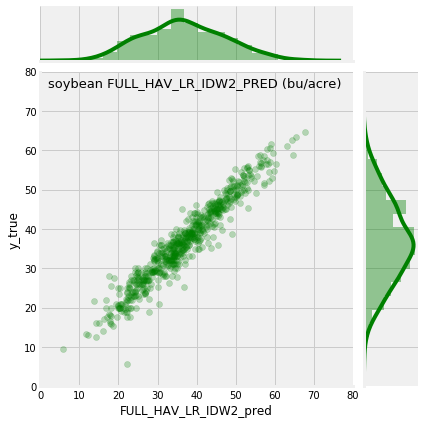

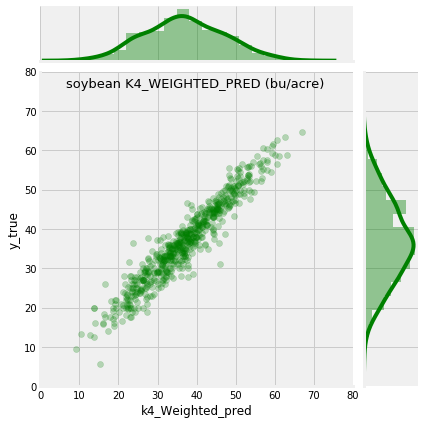

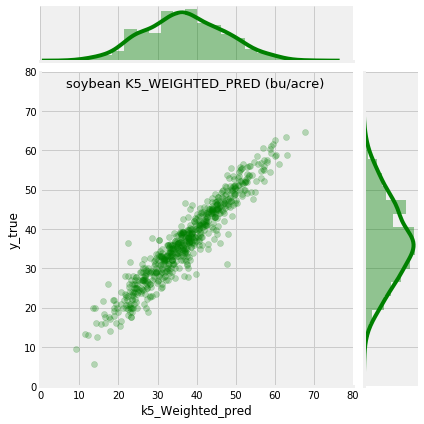

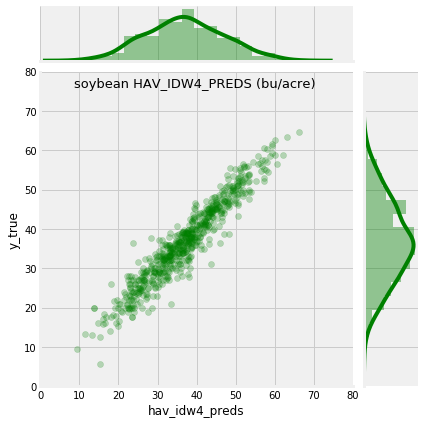

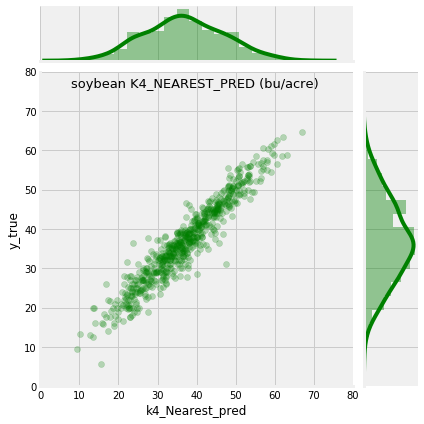

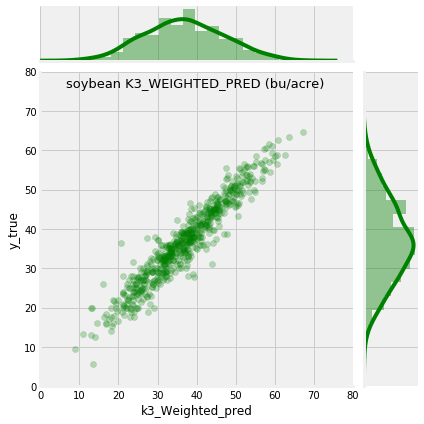

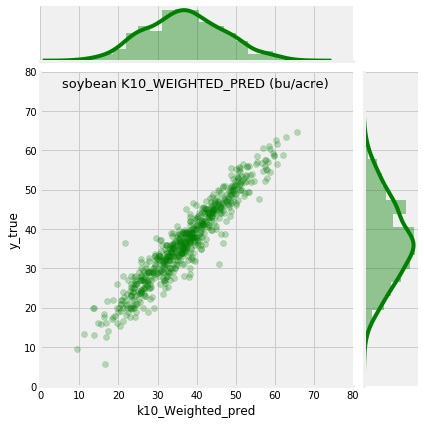

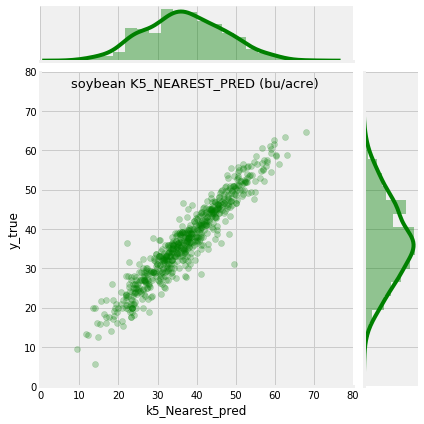

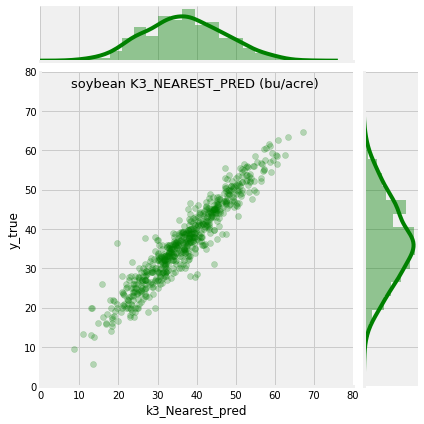

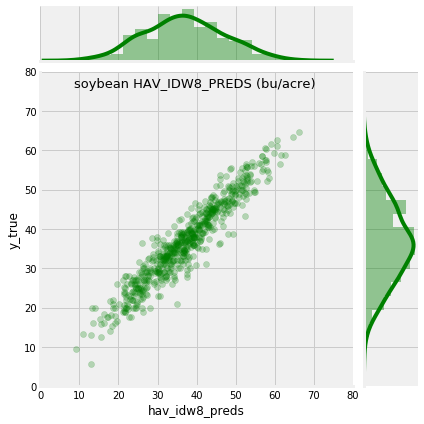

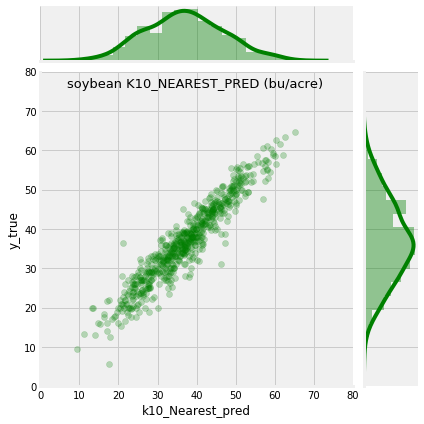

In [51]:
select_pred_cols = ['FULL_HAV_LR_IDW_pred', 'FULL_HAV_LR_IDW2_pred',
                    'k4_Weighted_pred', 'k5_Weighted_pred',
                    'hav_idw4_preds', 'k4_Nearest_pred',
                    'k3_Weighted_pred', 'k10_Weighted_pred',
                    'k5_Nearest_pred', 'k3_Nearest_pred',
                    'hav_idw8_preds', 'k10_Nearest_pred',]

for col in select_pred_cols: 
    g = sns.JointGrid(x=predictions[col], y=predictions['y_true'], 
                      xlim=(0,80), ylim=(0,80))
    g = g.plot_joint(plt.scatter, color='g', alpha=0.25)
    g = g.plot_marginals(sns.distplot, color='g')
    plt.suptitle("{} {} (bu/acre)".format(target_crop, col.upper()), 
                 x=0.46, y=0.81, fontsize=13)
    plt.show();
    print()

___